# sPlot

This notebook is devoted to explanation what is __sPlot__ and how to use `hep_ml.splot`.

__sPlot__ is a way to reconstruct features of mixture components based on known properties of distributions. This method is frequently used in High Energy Physics.

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 6]

In [2]:
size = 10000
sig_data = numpy.random.normal(-1, 1, size=size)
bck_data = numpy.random.normal(1, 1, size=size)

## Simple example of sPlot

First start from simple (and not very useful in practice) example.

Assume we have two types of particles (say, electrons and positrons). 

Distribuition of some characteristic is different for them (let this be px momentum projection).

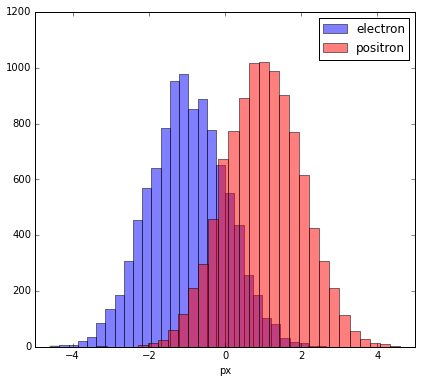

In [3]:
plt.subplot(121)
plt.hist(sig_data, color='b', alpha=0.5, bins=30, label='electron')
plt.hist(bck_data, color='r', alpha=0.5, bins=30, label='positron')
plt.xlim(-5, 5), plt.xlabel('px')
plt.legend()

## Observed distributions

Picture above shows how this distibution should look like, 
but due to inaccuracies during classification we will observe different picture.

Let's assume that with probability 80% particle is classified correctly (and we are not using px during classification).

And when we look at distribution of px for particles which were classified as electrons or positrons,
we see that they were distorted. We lost the original shapes of distributions.

In [4]:
n_sig1, n_bck1 = 8000, 2000
n_sig2, n_bck2 = 2000, 8000
first_bin = numpy.concatenate([sig_data[:n_sig1], bck_data[:n_bck1]])
second_bin = numpy.concatenate([sig_data[n_sig1:], bck_data[n_bck1:]])

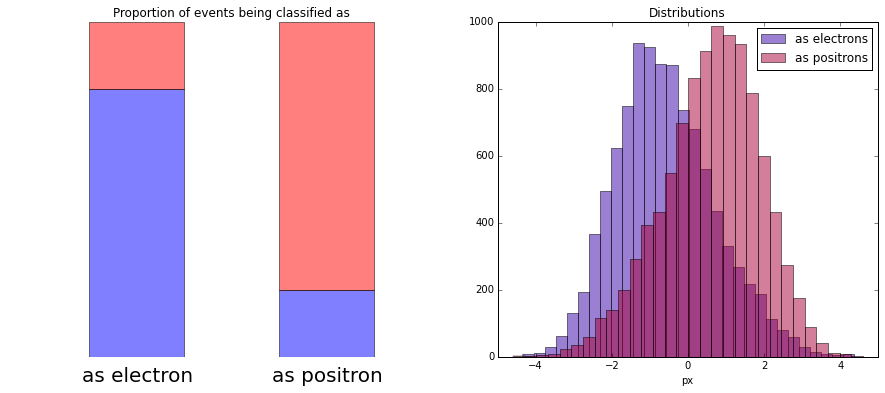

In [5]:
plt.subplot(121)
plt.bar([0, 2], [n_sig1, n_sig2], width=1, color='b', alpha=0.5)
plt.bar([0, 2], [n_bck1, n_bck2], width=1, bottom=[n_sig1, n_sig2], color='r', alpha=0.5)
plt.xlim(-0.5, 3.5)

plt.axis('off')
plt.xticks([0.5, 2.5], ['as electrons', 'as positrons'])
plt.text(0.5, -300, 'as electron', horizontalalignment='center', verticalalignment='top', fontsize=20)
plt.text(2.5, -300, 'as positron', horizontalalignment='center', verticalalignment='top', fontsize=20)
plt.title('Proportion of events being classified as')

plt.subplot(122)
plt.hist(first_bin, alpha=0.5, bins=30, label='as electrons', color=(0.22, 0., 0.66))
plt.hist(second_bin, alpha=0.5, bins=30, label='as positrons', color=(0.66, 0., 0.22))
plt.legend()
plt.title('Distributions')
plt.xlim(-5, 5), plt.xlabel('px')
pass

## Applying sWeights

We can think of it in the following way: there are 2 bins. In first 80% are electrons, 20% are signal. And visa versa in second bin.

To reconstruct initial distribution, we can plot histogram, where each event from first bin has weight 0.8, 
and each event from second bin has weight -0.2. This numbers are called sWeights. 

So, if we had 8000 $e^{-}$ + 2000 $e^{+}$ in first bin and 8000 $e^{+}$ + 2000 $e^{-}$ ($ e^-, e^+$ are electron and positron). After summing with introduced sWeights:

$$
\big[ 8000 e^{-} + 2000 e^{+} \big] \times 0.8 + \big[ 2000 e^{-} + 8000 e^{+} \big] \times (- 0.2) = 
6800 e^{-}
$$

Positrons with positive and negative weights compensated each other, and we will get pure electrons.

At this moment we ignore normalization of sWeights (because it doesn't play role when we want to reconstruct shape).



In [6]:
def plot_with_weights(datas, weights, **kargs):
    assert len(datas) == len(weights)
    data = numpy.concatenate(datas)
    weight = numpy.concatenate([numpy.ones(len(d)) * w for d, w in zip(datas, weights) ])
    plt.hist(data, weights=weight, alpha=0.5, bins=30, **kargs)

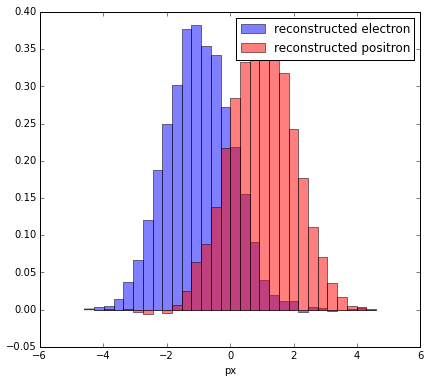

In [7]:
plt.subplot(121)
plot_with_weights([first_bin, second_bin], [n_bck2, -n_bck1], normed=True, label='reconstructed electron')
plot_with_weights([first_bin, second_bin], [-n_sig2, n_sig1], normed=True, color='r', label='reconstructed positron')
plt.xlabel('px')
plt.legend()
pass

### Compare

let's compare reconstructed distribution for electrons with original:

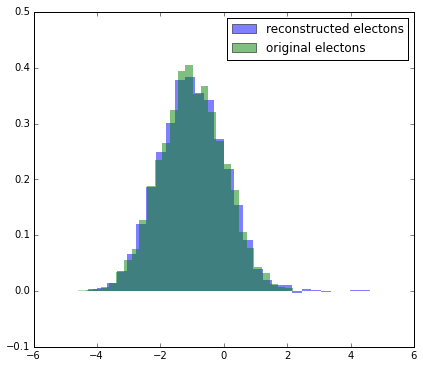

In [8]:
plt.subplot(121)
plot_with_weights([first_bin, second_bin], [n_bck2, -n_bck1], normed=True, label='reconstructed electons', edgecolor='none')
plot_with_weights([sig_data], [1], normed=True, label='original electons', edgecolor='none')
plt.legend()
pass

# More complex case

In the case when we have only two 'bins' is simple and straightforward. But when there are more than two bins, the solution is not unique. There are many appropriate combinations of sWeights, which one to choose? 

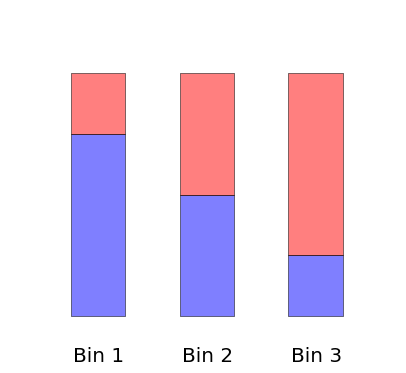

In [9]:
plt.subplot(121)

plt.bar([0, 2, 4], [3, 2, 1], width=1, color='b', alpha=0.5)
plt.bar([0, 2, 4], [1, 2, 3], width=1, bottom=[3, 2, 1], color='r', alpha=0.5)

plt.xlim(-1, 6)
plt.ylim(-0.5, 5)
plt.axis('off')

plt.text(0.5, -0.5, 'Bin 1', horizontalalignment='center', verticalalignment='top', fontsize=20)
plt.text(2.5, -0.5, 'Bin 2', horizontalalignment='center', verticalalignment='top', fontsize=20)
plt.text(4.5, -0.5, 'Bin 3', horizontalalignment='center', verticalalignment='top', fontsize=20)

but things in practice are more complex. We have not bins, but continuos distribution (which can be treated as many bins). 

Typically this is distribution over mass. By fitting mass we are able to split mixture into two parts: signal channel and everything else.

# Building sPlot over mass

Let's show how this works. First we generate two fake distributions (signal and background) with 2 variables: mass and momentum.

In [10]:
from scipy.stats import norm, expon

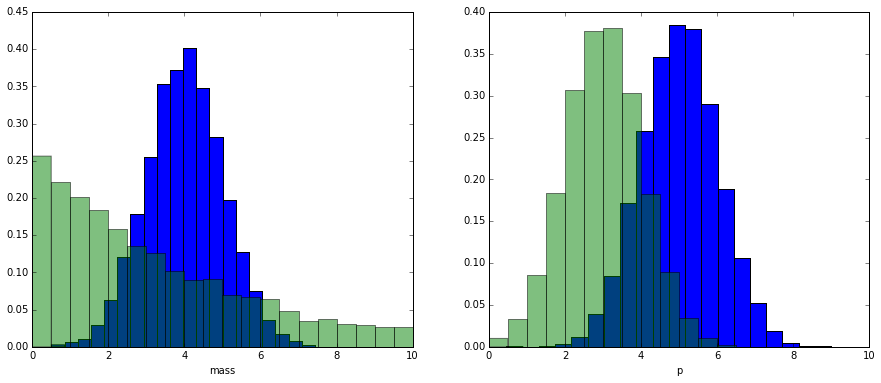

In [11]:
size = 10000

sig_mass_distr = norm(loc=4, scale=1)
bck_mass_distr = expon(scale=4)

sig_mass = sig_mass_distr.rvs(size=size)
bck_mass = bck_mass_distr.rvs(size=size)
sig_p = numpy.random.normal(5, 1, size=size)
bck_p = numpy.random.normal(3, 1, size=size)

plt.subplot(121)

plt.hist(sig_mass, bins=20, normed=True)
plt.hist(bck_mass, bins=20, normed=True, range=(0, 10), alpha=0.5)
plt.xlabel('mass')

plt.subplot(122)

plt.hist(sig_p, bins=20, normed=True)
plt.hist(bck_p, bins=20, normed=True, range=(0, 10), alpha=0.5)
plt.xlabel('p')

### Of course we don't have labels which events are signal and which are background before we actually.

And we observe the mixture of two distributions:

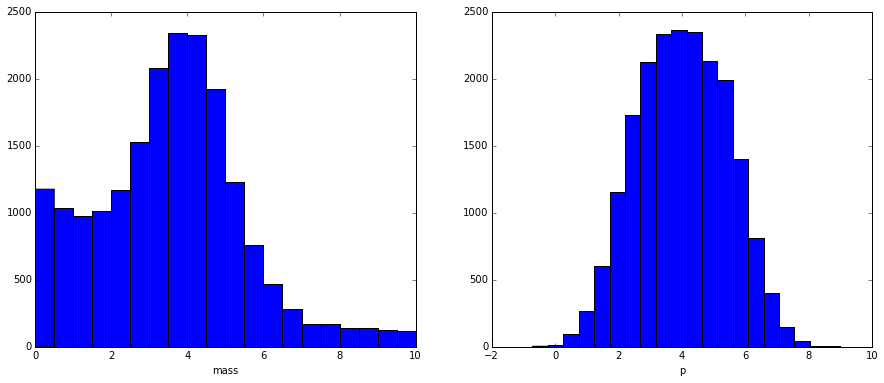

In [12]:
mass = numpy.concatenate([sig_mass, bck_mass])
p = numpy.concatenate([sig_p, bck_p])

sorter = numpy.argsort(mass)
mass = mass[sorter]
p = p[sorter]

plt.subplot(121)
plt.hist(mass, bins=20, range=(0, 10))
plt.xlabel('mass')

plt.subplot(122)
plt.hist(p, bins=20)
plt.xlabel('p')

### We have no information about real labels

But we know a priori that background is distributed as exponential distribution and signal - as gaussian (more complex models can be met in practice, but idea is the same).

After fitting the mixture (let me skip this process), we will get the following result:

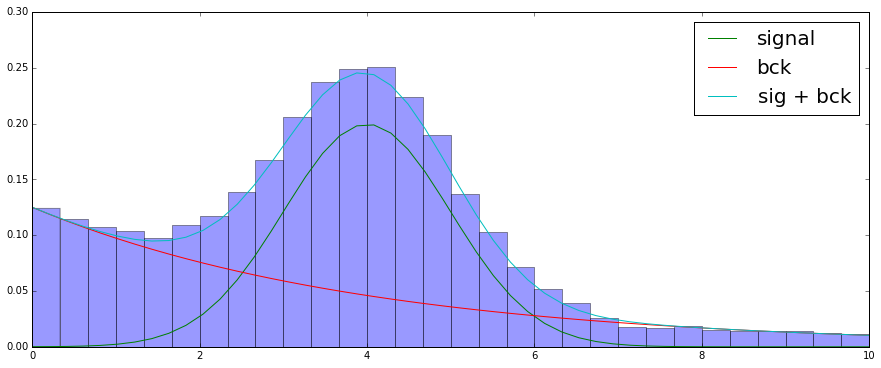

In [13]:
x = numpy.linspace(0, 10)
plt.hist(mass, bins=30, range=[0, 10], normed=True, alpha=0.4)
plt.plot(x, norm.pdf(x, loc=4, scale=1) / 2., label='signal')
plt.plot(x, expon.pdf(x, scale=4) / 2., label='bck')
plt.plot(x, 0.5 * (norm.pdf(x, loc=4, scale=1) + expon.pdf(x, scale=4)), label='sig + bck')
plt.legend(fontsize=20)

## Fitting doesn't give us information about real data

But it gives information about real labels, but now we can estimate number of signal and background events within each bin. 

But instead we will get for each event probability that it is signal or background:

In [14]:
import pandas
probs = pandas.DataFrame(dict(sig=sig_mass_distr.pdf(mass), bck=bck_mass_distr.pdf(mass)))
probs = probs.div(probs.sum(axis=1), axis=0)

((0, 10),
 <matplotlib.text.Text at 0x1116ff5d0>)

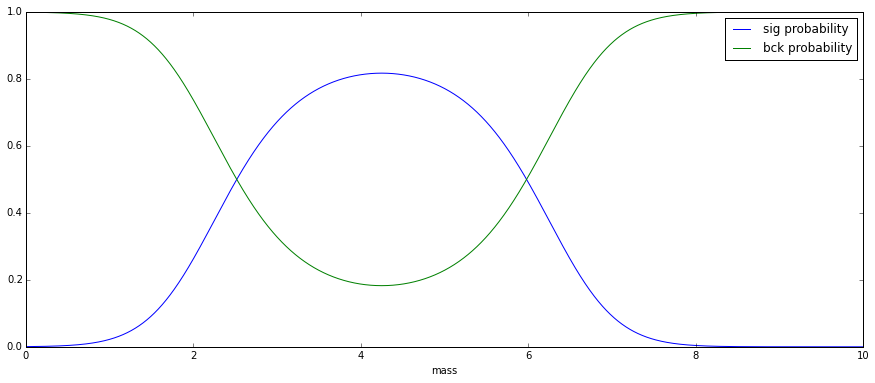

In [15]:
plt.plot(mass, probs.sig, label='sig probability')
plt.plot(mass, probs.bck, label='bck probability')
plt.xlim(0, 10), plt.legend(), plt.xlabel('mass')

## Appying sPlot

sPlot converts probabilities to sWeights, using implementation from `hep_ml`:

As you can see, there are also negative sWeights, which are needed to compensate the contributions of other class.

In [16]:
from hep_ml import splot
sWeights = splot.compute_sweights(probs)

((0, 10),
 <matplotlib.text.Text at 0x111e1aa50>)

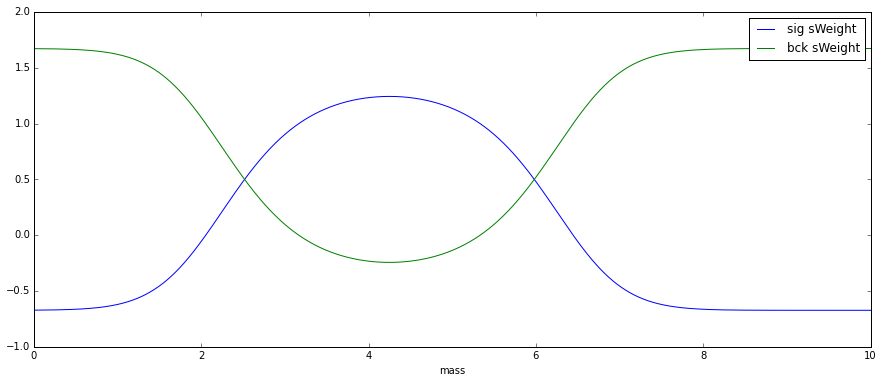

In [17]:
plt.plot(mass, sWeights.sig, label='sig sWeight')
plt.plot(mass, sWeights.bck, label='bck sWeight')
plt.xlim(0, 10), plt.legend(), plt.xlabel('mass')

## Using sWeights to reconstruct initial distribution

Let's check that we archieved our goal and can reconstruct momentum distribution for signal and background:

(<matplotlib.text.Text at 0x11329ba10>,
 <matplotlib.legend.Legend at 0x1132bdf50>)

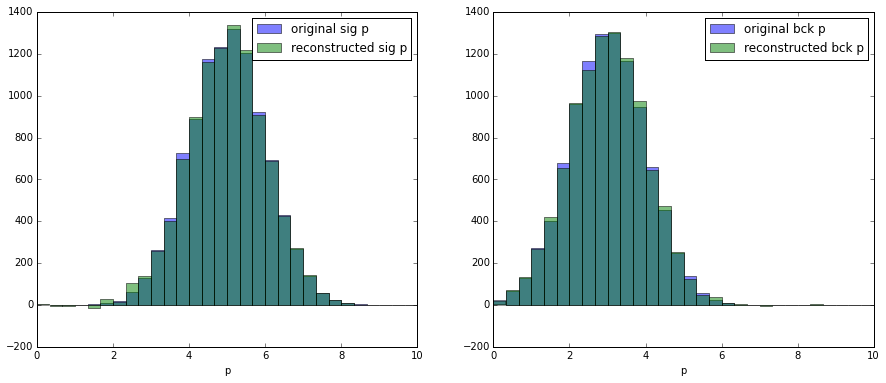

In [18]:
plt.subplot(121)
hist_conf = dict(bins=30, alpha=0.5, range=[0, 10])
plt.hist(sig_p, label='original sig p', **hist_conf)
plt.hist(p, weights=sWeights.sig, label='reconstructed sig p', **hist_conf)
plt.xlabel('p'), plt.legend()

plt.subplot(122)
plt.hist(bck_p, label='original bck p', **hist_conf)
plt.hist(p, weights=sWeights.bck, label='reconstructed bck p', **hist_conf)
plt.xlabel('p'), plt.legend()

## Important requirement of sPlot

Reconstructed variable (i.e. $p$) and splotted variable (i.e. mass) shall be statistically independent for each class.

Read the line above again. Reconstructed and splotted variable are correlated:

In [19]:
numpy.corrcoef(abs(mass - 4), p) [0, 1]

-0.32706933369071883

But within each class there is no correlation, so the requirement is satisfied:

In [20]:
print numpy.corrcoef(abs(sig_mass - 4), sig_p)[0, 1]
print numpy.corrcoef(abs(bck_mass - 4), bck_p)[0, 1]

0.000511827698517
0.0106987001745


as a demonstration why this is important let's use sweights to reconstruct mass (obviously mass is correlated with mass):

(<matplotlib.text.Text at 0x11076c5d0>,
 <matplotlib.legend.Legend at 0x113384750>)

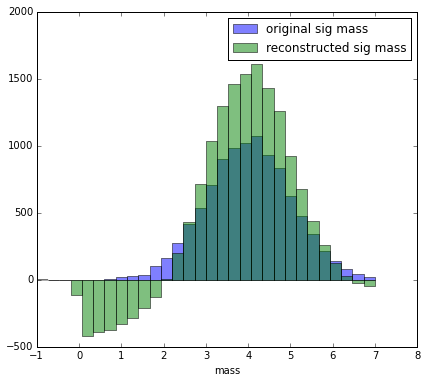

In [21]:
plt.subplot(121)
hist_conf = dict(bins=30, alpha=0.5, range=[-1, 7])
plt.hist(sig_mass, label='original sig mass', **hist_conf)
plt.hist(mass, weights=sWeights.sig, label='reconstructed sig mass', **hist_conf)
plt.xlabel('mass'), plt.legend()

$\def\ps{p_s(x)}$
$\def\pb{p_b(x)}$
$\def\ws{sw_s(x)}$
$\def\wb{sw_b(x)}$



# Derivation of sWeights

Now, after we seen how this works, let's derive formula for sWeights.



The only information we have from fitting over mass is  $ \ps $, $ \pb$ which are probabilities of event $x$ to be signal and background. 

Our main goal is to correctly reconstruct histogram. Let's reconstruct the number of _signal_ events in _particular_ bin. Let's introduce unknown $p_s$ and $p_b$ - probability that signal or background event will be in the named bin.

(Since mass and reconstructed variable are statistically independent for each class, $p_s$ and $p_b$ do not depend on mass.)

The mathematical expectation should be obviously equal to $p_s N_s$, where $N_s$ is total amount of signal events available from fitting.

Let's also introduce random variable $1_{x \in bin}$, which is 1 iff event $x$ lies in selected bin. 

The __estimate for number of signal event in bin__ is equal to:
$$X = \sum_x \ws \; 1_{x \in bin},$$ where $\ws$ are sPlot weights and are subject to find.



## First main property of sweights


__Property 1. __ We expect out estimation to be unbiased
$$\mathbb{E} \, X = p_s N_s $$


__Corollary__ 
Let's understand what this means for sPlot weights.

$ p_s N_s = \mathbb{E} \, X = \sum_x w_s \; \mathbb{E} \, 1_{x \in bin} 
= \sum_x w_s \;  (p_s \ps + p_b \pb) $

In the line above I used the assumption that variables are statistically independent for each class.

Since the previous equation should hold for all possible $p_s$ and $p_b$, we get two equalities:
<br />$ p_s N_s = \sum_x \ws \; p_s \ps  $
<br />$ 0 = \sum_x \ws \; p_b \pb $

After reduction:
<br />$ N_s = \sum_x \ws \; \ps  $
<br />$ 0 = \sum_x \ws \; \pb $


This way we can guarantee that mean input of background are 0 (expectation is zero, but observed number will not be zero due to statistical deviation), and the expected number of background 

## Under assumption of linearity:
assuming that splot weight can be computed as linear combination of conditional probabilities:

$ \ws = a_1 \pb + a_2 \ps$

We can easily reconstruct those numbers, first let's rewrite our system:

$ \sum_x (a_1 \pb + a_2 \ps) \; \ps = 0$ <br />
$ \sum_x (a_1 \pb + a_2 \ps) \; \pb = N_{sig}$

$ a_1 V_{bb} + a_2 V_{bs} = 0$ <br />
$ a_1 V_{sb} + a_2 V_{ss} = N_{sig}$ <br />

Where 
$V_{ss} = \sum_x \ps \; \ps $, $V_{bs} = V_{sb} = \sum_x \ps \; \pb$, $V_{bb} = \sum_x \pb \; \pb$

Having solved this linear equation, we get needed coefficients (as those in the paper)

NB. There is little difference between $V$ matrix I use and $V$ matrix in the paper. <br />


## Minimization of variation
$\def\Var{\mathbb{V}\,}$

Previous part allows one to get the correct result. But there is still no explanation of reason for linearity.


Apart from having correct mean, we should also minimize variation of any reconstructed variable. Let's try optimize it 

$$ \Var X = \sum_x \ws^2 \; \Var 1_{x \in bin} = \sum_x \ws^2 \; (p_s \ps + p_b \pb)(1 - p_s \ps - p_b \pb)$$

A bit complex, isn't it? Instead of optimizing such a complex expression (which is individual for each bin), let's minimize it's __uniform upper estimate__
$$ \Var X = \sum_x \ws^2 \; \Var 1_{x \in bin} \leq  \sum_x \ws^2  $$



so if we are going to minimize this upper estimate, we should solve the following optimization problem with constraints:
<br />$\sum_x \ws^2 \to \min $
<br />$\sum_x \ws \; \pb = 0$ 
<br />$\sum_x \ws \; \ps = N_{sig}$

Let's write lagrangian of optimization problem:
<br /> $$ \mathcal{L} =  \sum_x \ws^2 
+ \lambda_1 \left[\sum_x \ws \; \pb \right]
+ \lambda_2 \left[\sum_x \ws \; \ps - N_{sig} \right]$$

After taking derivative with respect to $ \ws $ we get the equality:
$$
0 = \dfrac{\partial \mathcal{L}}{\partial \; \ws} =   2 \ws
+ \lambda_1  \pb
+ \lambda_2  \ps
$$

which holds for every $x$. Thus, after renaming for convenience 
$a_1 = - \lambda_1 / 2, $
$a_2 = - \lambda_2 / 2, $
we are getting needed linear dependency. 

### Uncorrelatedness

The main assuption we used here is that distribution inside each bin is abolutely indentical.

In other words, we stated that there is no correlation between the index of bin and the reconstructed variable. Remember that bin corresponds to some interval in mass, and finaly we get:

__reconstructed variable shall not be correlated with mass variables (or any other splotted variable)__

# Conclusion

1. sPlot allows reconstruction of some variables.
2. the only information used is probabilities taken from fit over variable. If fact, any probability estimates fit well.
3. the source of probabilities should be statistically independent from reconstructed variable (for each class!).
4. mixture may contain more than 2 classes (this is supported by `hep_ml.splot` as well)